In [1]:
from math import log2, log10
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cotengra as ct
from tqdm import tqdm
from _sat import CNFInstance

c:\Users\Stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


# Random K-SAT Contraction Experiments

## Baby Example - Minuscule 3-SAT instance

In [2]:
cnf_instance = CNFInstance.random(k=3, n=4, m=4, rng=0)
cnf_instance.clauses

((2, 3, 4), (-4, -3, -1), (-3, -2, 4), (-4, -3, 1))

From DIMACS to variable names:

```
((2, 3, 4),   (-4, -3, -1),   (-3, -2, 4),  (-4, -3, 1))
 (x1|x2|x3) & (~x3|~x2|~x0) & (~x2|~x1|x3) &(~x3|~x2|x0)
```

Variables are (hyper-)edges, operations are nodes:

- `true: 0 -> 1`
- `not: 1 -> 1`
- `or: 2 -> 1`

Open (hyper-)edges, the ones with a dangling edge, are the input variables.

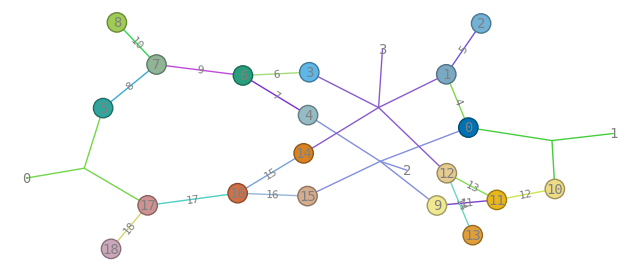

In [3]:
network = cnf_instance.network()
network.wiring.hypergraph.plot(
    figsize=(8, 8),
    hyperedge_style="solid",
);

The network above, written as a program:

```
inputs: x0, x1, x2, x3
operations:
  clause (x1|x2|x3):
    0: x4 := x1 or x2
    1: x5 := x4 or x3
    2: assert x5 == true
  clause (~x3|~x2|~x0):
    3: x6  := not x3
    4: x7  := not x2
    5: x8  := not x0
    6: x9  := x6 or x7
    7: x10 := x8 or x9
    8: assert x10 == true
  clause (~x2|~x1|x3):
    9: x11 := not x2
    10: x12 := not x1
    11: x13 := x11 or x12
    12: x14 := x13 or x3
    13: assert x14 == true
  clause (~x3|~x2|x0):
    14: x15 := not x3
    15: x16 := not x2
    16: x17 := x15 or x16
    17: x18 := x17 or x0
    18: assert x18 == true
```

## Example - Tiny 4-SAT instance

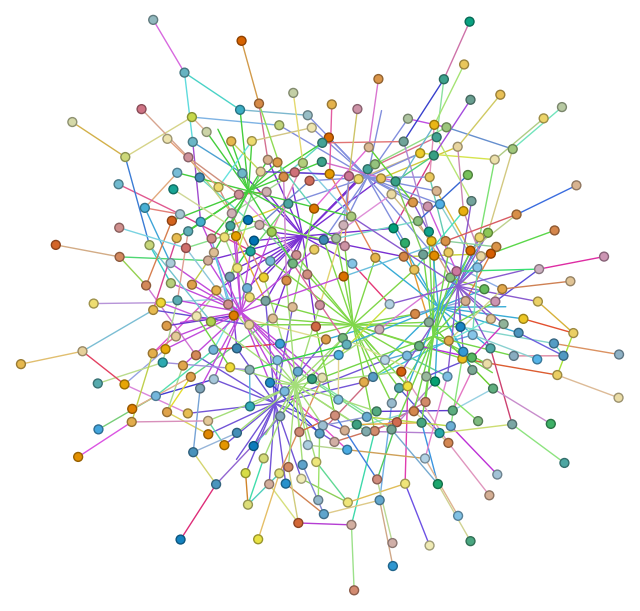

In [4]:
cnf_instance = CNFInstance.random(k=4, n=10, m=50, rng=0)
network = cnf_instance.network()
network.wiring.hypergraph.plot(
    figsize=(8, 8),
    hyperedge_style="solid",
);

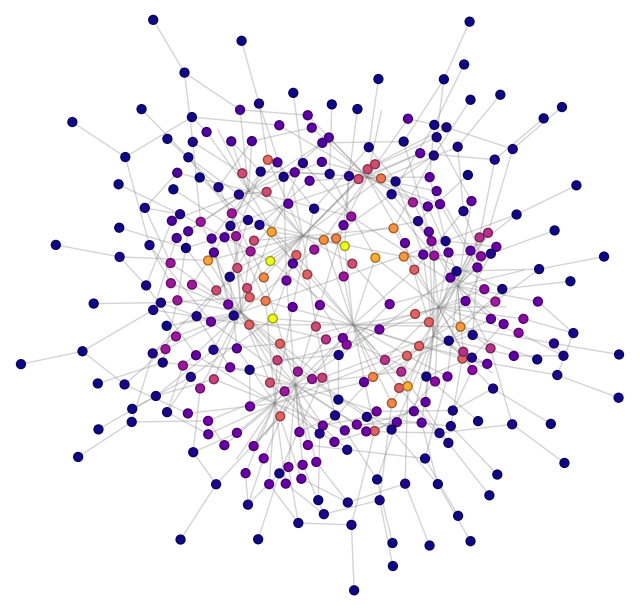

In [5]:
network.wiring.hypergraph.plot(
    figsize=(8, 8),
    hyperedge_style="solid",
    node_color="centrality",
    edge_color=False
);

t.total_flops() = 22848
t.total_write() = 13768B
t.max_size() = 1024B
t.peak_size() = 3964B


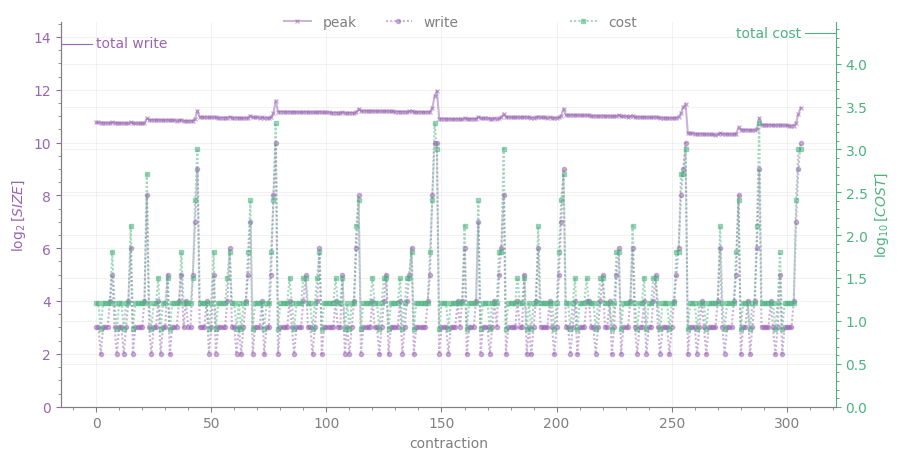

In [6]:
t = network.wiring.contraction_tree
print(f"{t.total_flops() = }")
print(f"{t.total_write() = }B")
print(f"{t.max_size() = }B")
print(f"{t.peak_size() = }B")
t.plot_contractions(figsize=(10, 5));

References on dynamic slicing and subtree reconfiguration:

- https://cotengra.readthedocs.io/en/latest/advanced.html
- https://cotengra.readthedocs.io/en/latest/trees.html#dynamic-slicing
- https://cotengra.readthedocs.io/en/latest/autoapi/cotengra/index.html#cotengra.ContractionTree.slice_and_reconfigure


In [7]:
t_sl = t.slice_and_reconfigure(
    target_size=2**6, # max intermediate tensor size
    progbar=True
)

log10[FLOPs]=4.706 log2[SIZE]=6: : 4it [00:18,  4.63s/it] 


t.total_flops() = 22848
t.total_write() = 13768B
t.max_size() = 1024B
t.peak_size() = 3964B
Slicing overhead = +122%
Slicing memory reduction = -63%
Num slices = 4


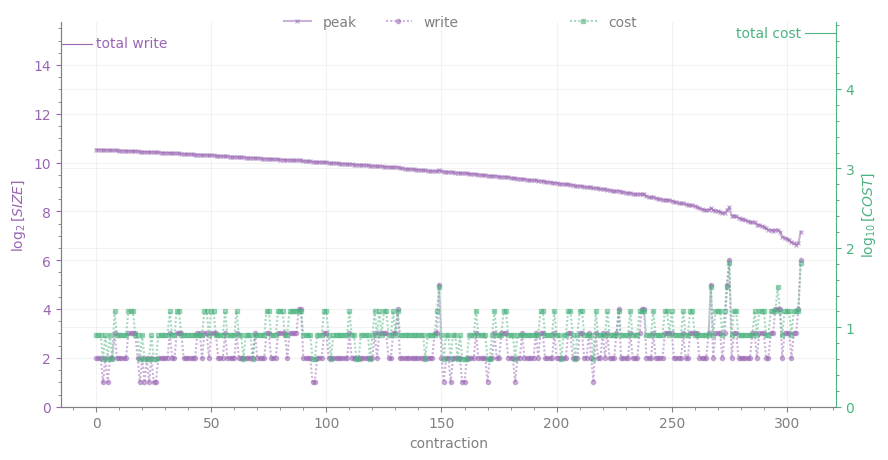

In [8]:
print(f"{t.total_flops() = }")
print(f"{t.total_write() = }B")
print(f"{t.max_size() = }B")
print(f"{t.peak_size() = }B")
print(f"Slicing overhead = {t_sl.total_flops()/t.total_flops()-1:+.0%}")
print(f"Slicing memory reduction = {t_sl.peak_size()/t.peak_size()-1:+.0%}")
print(f"Num slices = {len(t_sl.sliced_inds)}")
t_sl.plot_contractions(figsize=(10, 5));

## Experiment 1 - Unsliced Peak Size

In this experiment, we look at the memory requirements for unsliced tensor contraction of randomly generated 4-SAT instances in CNF form, as the number of variables is increased with a fixed clause-to-variable ratio $\alpha = 9.75$, chosen to be in the condensation phase (cf. Figure 3 of http://arxiv.org/abs/0802.3627v2).

The data for this experiment was serialised because it takes around 20m to compute it.

In [ ]:
# k = 4
# alpha = 9.75
# num_samples = 100
# _sizes: list[list[int]] = []
# for num_vars in tqdm(range(5, 21, 1)):
#     num_vars_sizes: list[int] = []
#     num_clauses = int(alpha * num_vars)
#     for i in range(num_samples):
#         cnf_instance = CNFInstance.random(k=k, n=num_vars, m=num_clauses, rng=i)
#         network = cnf_instance.network()
#         t = network.wiring.contraction_tree
#         num_vars_sizes.append(t.peak_size())
#     _sizes.append(num_vars_sizes)
# sizes = np.array(_sizes)
# np.save("random-ksat-contraction-data/experiment-1-sizes.npy", sizes)
sizes = np.load("random-ksat-contraction-data/experiment-1-sizes.npy")

log2(bytes) ≅ 0.87n + 11.16


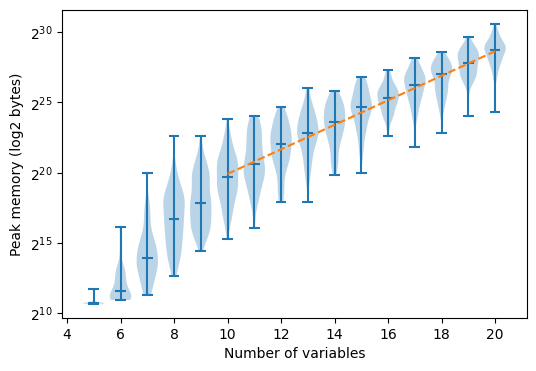

In [61]:
from scipy.stats import linregress
x = np.arange(5, 21, 1)[5:]
y = np.mean(np.log2(sizes[5:,:]), axis=1)
slope, intercept, _, _, _ = linregress(x, y)
print(f"log2(bytes) ≅ {slope:.2f}n + {intercept:.2f}")

plt.figure(figsize=(6, 4))
plt.violinplot(
    np.log2(sizes.T),
    positions=range(5, 21, 1),
    widths=0.8,
    showextrema=True,
    showmedians=True,
)
plt.plot(x, slope*x + intercept, linestyle="--")
plt.xlabel("Number of variables")
plt.ylabel("Peak memory (log2 bytes)")
plt.yticks(np.arange(10, 31, 5), [f"$2^{{{i}}}$" for i in range(10, 31, 5)])
plt.show()

## Experiment 2 - Sliced Peak Size and Total Flops

We repeat the previous experiment, but this time we fix a maximum size of 4MiB for any individual tensor, and we look at the difference between the total computational costs and peak memory sizes for unsliced vs sliced contractions.

The maximum size is set to 4MiB purely to exemplify the behaviour within reasonable experiment times: in real scenarios, the limitation would be of the order of the available GPU memory. 

The data for this experiment was serialised because it takes around 1h30m to compute it.

In [190]:
k = 4
alpha = 9.75
num_samples = 100
max_size = 2**22
num_vars_range = np.arange(5, 21, 1)
# _unsliced_sizes: list[list[int]] = []
# _sliced_sizes: list[list[int]] = []
# _unsliced_flops: list[list[int]] = []
# _sliced_flops: list[list[int]] = []
# for num_vars in tqdm(num_vars_range):
#     row_unsliced_sizes: list[list[int]] = []
#     row_sliced_sizes: list[list[int]] = []
#     row_unsliced_flops: list[list[int]] = []
#     row_sliced_flops: list[list[int]] = []
#     num_clauses = int(alpha * num_vars)
#     for i in range(num_samples):
#         cnf_instance = CNFInstance.random(k=k, n=num_vars, m=num_clauses, rng=i)
#         network = cnf_instance.network()
#         t = network.wiring.contraction_tree
#         t_sl = t.slice_and_reconfigure(target_size=max_size)
#         row_unsliced_sizes.append(t.peak_size())
#         row_sliced_sizes.append(t_sl.peak_size())
#         row_unsliced_flops.append(t.total_flops())
#         row_sliced_flops.append(t_sl.total_flops())
#     _unsliced_sizes.append(row_unsliced_sizes)
#     _sliced_sizes.append(row_sliced_sizes)
#     _unsliced_flops.append(row_unsliced_flops)
#     _sliced_flops.append(row_sliced_flops)
# unsliced_sizes = np.array(_unsliced_sizes)
# sliced_sizes = np.array(_sliced_sizes)
# unsliced_flops = np.array(_unsliced_flops)
# sliced_flops = np.array(_sliced_flops)
# with open("data/experiment-2-arrays.pickle", "wb") as f:
#     pickle.dump((unsliced_sizes, sliced_sizes, unsliced_flops, sliced_flops), f)
with open("data/experiment-2-arrays.pickle", "rb") as f:
    unsliced_sizes, sliced_sizes, unsliced_flops, sliced_flops = pickle.load(f)

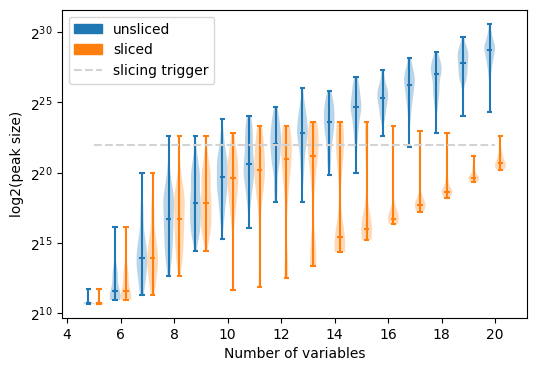

In [208]:
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 4))
plt.violinplot(
    np.log2(unsliced_sizes.T),
    positions=np.arange(5, 21, 1)-0.2,
    widths=0.4,
    showextrema=True,
    showmedians=True
)
plt.violinplot(
    np.log2(sliced_sizes.T),
    positions=np.arange(5, 21, 1)+0.2,
    widths=0.4,
    showextrema=True,
    showmedians=True
)
plt.plot(np.arange(5, 21, 1), np.ones(16)*22, color="lightgray", linestyle="--")
plt.gca().legend(handles=[
    Patch(color='tab:blue', label='unsliced'),
    Patch(color='tab:orange', label='sliced'),
    Line2D([0], [0], color='lightgray', linestyle="--", label="slicing trigger")
], loc="upper left")
plt.xlabel("Number of variables")
plt.ylabel("log2(peak size)")
plt.yticks(np.arange(10, 31, 5), [f"$2^{{{i}}}$" for i in range(10, 31, 5)])
plt.show()

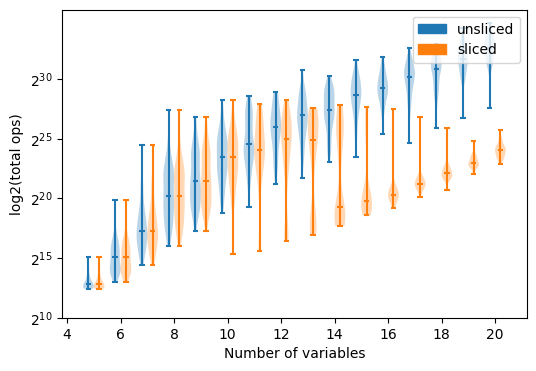

In [192]:
plt.figure(figsize=(6, 4))
plt.violinplot(
    np.log2(unsliced_flops.T),
    positions=num_vars_range-0.2,
    widths=0.4,
    showextrema=True,
    showmedians=True
)
plt.violinplot(
    np.log2(sliced_flops.T),
    positions=num_vars_range+0.2,
    widths=0.4,
    showextrema=True,
    showmedians=True
)
plt.gca().legend(handles=[
    Patch(color='tab:blue', label='unsliced'),
    Patch(color='tab:orange', label='sliced')
])
plt.xlabel("Number of variables")
plt.ylabel("log2(total ops)")
plt.yticks(np.arange(10, 31, 5), [f"$2^{{{i}}}$" for i in range(10, 31, 5)])
plt.show()

## Experiment 3 - 128GiB 4-SAT Instance

In [166]:
num_vars = 30
alpha = 9.75
cnf_instance = CNFInstance.random(k=4, n=num_vars, m=int(alpha*num_vars), rng=0)
network = cnf_instance.network()

The contraction tree for this instance was pickled because it takes about 5m to compute it.

In [168]:
# t = network.wiring.contraction_tree
# with open("data/experiment-3-unsliced-tree.pickle", "wb") as f:
#     pickle.dump(t, f)
with open("data/experiment-3-unsliced-tree.pickle", "rb") as f:
    t: ct.ContractionTree = pickle.load(f)

log10(t.total_flops()) = 12.46
log2(t.total_write()) = 38.27
log2(t.max_size()) = 36.00
log2(t.peak_size()) = 37.09


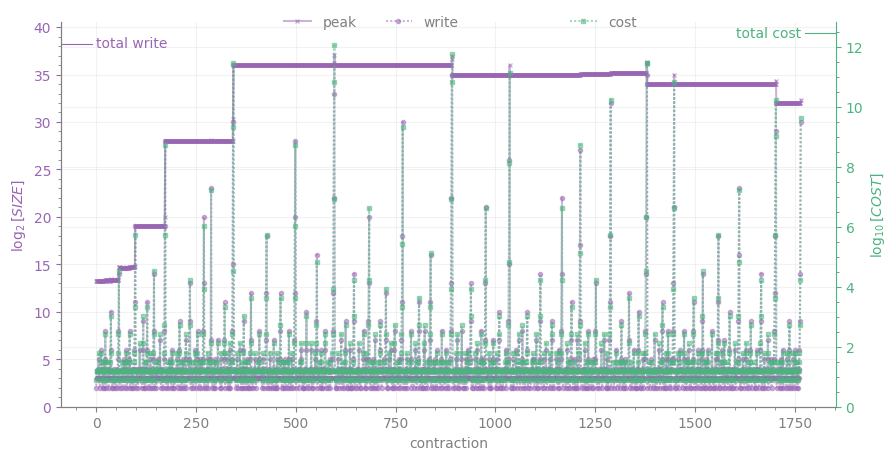

In [169]:
print(f"{log10(t.total_flops()) = :.2f}")
print(f"{log2(t.total_write()) = :.2f}")
print(f"{log2(t.max_size()) = :.2f}")
print(f"{log2(t.peak_size()) = :.2f}")
t.plot_contractions(figsize=(10, 5));

In this example, a single slice is sufficient to reduce the peak size from ~128GiB to less than 2GiB.

In [212]:
# t_sl = t.slice_and_reconfigure(target_size=2**35)
# with open("data/experiment-3-sliced-tree.pickle", "wb") as f:
#     pickle.dump(t_sl, f)
with open("data/experiment-3-sliced-tree.pickle", "rb") as f:
    t_sl: ct.ContractionTree = pickle.load(f)

log2(t_sl.total_flops()) = 31.36
log2(t_sl.total_write()) = 31.35
log2(t_sl.max_size()) = 20.00
log2(t_sl.peak_size()) = 21.00
Num slices = 10


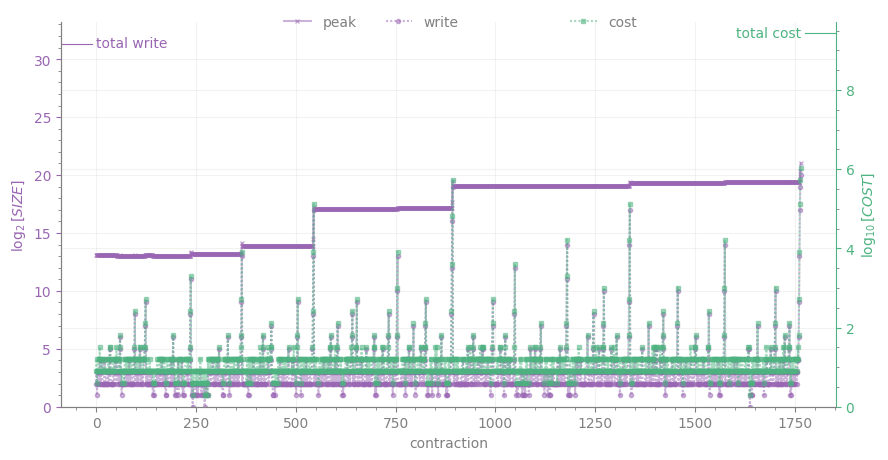

In [225]:
print(f"{log2(t_sl.total_flops()) = :.2f}")
print(f"{log2(t_sl.total_write()) = :.2f}")
print(f"{log2(t_sl.max_size()) = :.2f}")
print(f"{log2(t_sl.peak_size()) = :.2f}")
print(f"Num slices = {len(t_sl.sliced_inds)}")
t_sl.plot_contractions(figsize=(10, 5));

We can try to progressively reduce the max intermediate tensor size:

In [218]:
max_size_range = range(40, 19, -1)
sliced_trees = []
t_sl = t
for log2_max_size in tqdm(max_size_range):
    if 2**log2_max_size >= t_sl.max_size():
        sliced_trees.append(t_sl)
    else:
        t_sl = t_sl.slice_and_reconfigure(target_size=2**log2_max_size)
        sliced_trees.append(t_sl)
# with open("data/experiment-3-sliced-trees-40to20.pickle", "wb") as f:
#     pickle.dump(sliced_trees, f)
# with open("data/experiment-3-sliced-trees-40to20.pickle", "rb") as f:
#     sliced_trees = pickle.load(f)


100%|██████████| 21/21 [01:34<00:00,  4.48s/it]


The first two slices bring the initial max size down from 64 GiB to 1GiB and 256MiB, respectively.
Below 256MiB ($2^{28}$ bytes), we start trading memory for time: total ops and total write are unchanged,
while the max size and peak size continue do half with each new slice we introduce.

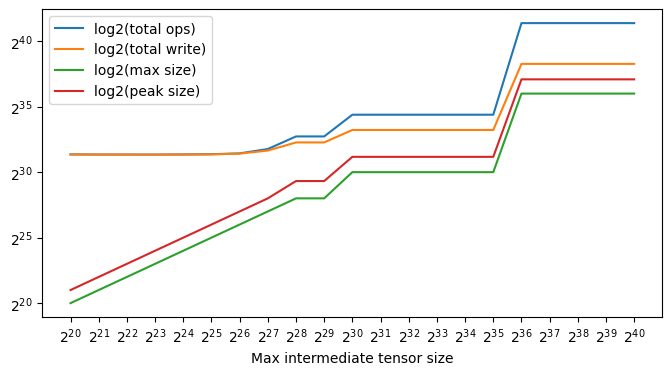

In [230]:
total_flops_sl = np.array([t_sl.total_flops() for t_sl in sliced_trees])
total_write_sl = np.array([t_sl.total_write() for t_sl in sliced_trees])
max_size_sl = np.array([t_sl.max_size() for t_sl in sliced_trees])
peak_size_sl = np.array([t_sl.peak_size() for t_sl in sliced_trees])

plt.figure(figsize=(8, 4))
plt.plot(max_size_range, np.log2(total_flops_sl), label="log2(total ops)")
plt.plot(max_size_range, np.log2(total_write_sl), label="log2(total write)")
plt.plot(max_size_range, np.log2(max_size_sl), label="log2(max size)")
plt.plot(max_size_range, np.log2(peak_size_sl), label="log2(peak size)")
plt.xticks(np.arange(40, 19, -1), [f"$2^{{{i}}}$" for i in range(40, 19, -1)])
plt.yticks(np.arange(20, 41, 5), [f"$2^{{{i}}}$" for i in range(20, 41, 5)])
plt.xlabel("Max intermediate tensor size")
plt.legend()
plt.show()

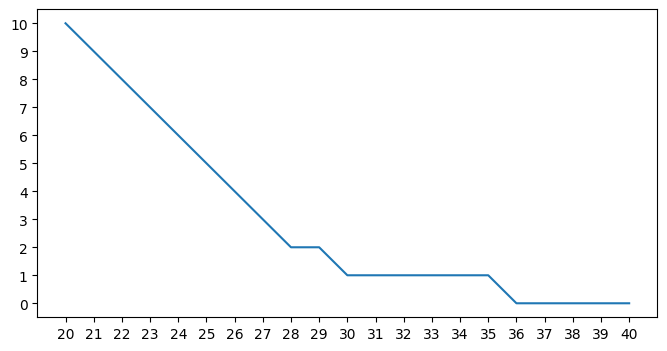

In [231]:
num_slices = np.array([len(t_sl.sliced_inds) for t_sl in sliced_trees])
plt.figure(figsize=(8, 4))
plt.plot(max_size_range, num_slices, label="num slices")
plt.xticks(np.arange(40, 19, -1),)
plt.yticks(range(11))
plt.show()